# Fit LR with lasso regularization with CV-5

## Load generic libraries

In [1]:
#from __future__ import division
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
#load ML libraries
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import ShuffleSplit

## Load method-specific libraries

In [7]:
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
#from sklearn.preprocessing import PolynomialFeatures
# Finally, import function to make a machine learning pipeline

## Define functions

In [15]:
# output performance metrics
def output_metrics(X_train, y_train, X_test, y_test, model, method, cv=5):
    print("{method} R-squared for train: %.4f".format(method=method) % (r2_score(y_train, model.predict(X_train))))
    print("{method} R-squared for CV: %.4f".format(method=method) % 
          (cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()))
    #
    MSE_train = mean_squared_error(y_train, model.predict(X_train))
    MSE_CV = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    print("{method} MSE for train: %.4f".format(method=method) % (MSE_train))
    print("{method} MSE for CV: %.4f".format(method=method) % (MSE_CV))
    print("{method} MSE_CV/MSE_train: %.4f".format(method=method) % (MSE_CV/MSE_train))
    #
    print()
    print("{method} R-squared for test: %.4f".format(method=method) % (r2_score(y_test, model.predict(X_test))))
    print("{method} MSE for test: %.4f".format(method=method) % (mean_squared_error(y_test, model.predict(X_test))))

In [25]:
# list 20 (or different number) most important features or features with non-zero coefficients
# for non-zero coefficients (LASSO) mode='non-zero'
def output_important_features(model, X, mode='importance', number_important=-1):
    if mode == 'importance':
        print("Feature Importances:")
        print()
        feat_importance = pd.Series(model.feature_importances_, index=X.columns)
        feat_importance = feat_importance.sort_values(ascending=False)
        print(feat_importance[:number_important])
    elif mode == 'non-zero':
        print("Features with non-zero coefficients:")
        print()
        feat_importance = pd.Series(model.coef_, index=X.columns)
        feat_importance = feat_importance.sort_values(ascending=False)
        print(feat_importance[feat_importance != 0][:number_important])    

In [17]:
# function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, figsize=(10, 7),
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=figsize, dpi=200, facecolor='w', edgecolor='k')
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R-2 score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Define model learning parameters

In [18]:
# these ones stay the same
cv = 5
test_size = 0.2
random_state = 229
# this one is method specific
method = 'Linreg LASSO'

## Load data, split in train and test sets

In [3]:
# read data in
df = pd.read_csv('data/df_52feat.csv', header=0, index_col=0)
df.head(3)

,PicCount,List Price,Sold Price,Tot BR,Tot Baths,TotFlArea,Age,TotalPrkng,# Rms,Fireplaces,...,District 12,District 25,District 4,District 32,District 5,District 23,District 19,District 2,DOM,Address_IsPH
R2050687,-2.302161,-0.861236,-0.914670,-0.657683,-0.807609,-0.862037,-0.520211,-0.127012,-1.111587,1.527118,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
R2050161,-2.643100,-0.344493,-0.385520,0.869434,0.947883,0.213822,-0.287701,-0.127012,0.155713,1.527118,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,1
R2049384,0.766285,-0.038619,0.480363,0.869434,0.947883,0.086644,0.099816,-0.127012,0.155713,1.527118,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0


In [19]:
num_features = ['PicCount', 'Tot BR', 'Tot Baths', 'TotFlArea', 'Age','TotalPrkng', '# Rms',
                'Fireplaces', 'Gross Taxes', 'Strata Maint Fee', 'View_Score', 'Baths']
not_features = ['List Price', 'Sold Price', 'DOM', 'Taxes/TotFlArea']

In [20]:
# define feature matrix and response variable
X = df.drop(not_features, axis=1)
# use numerical features only
#X = df[num_features]
y = df['Sold Price']

In [21]:
# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

## Fit LR with lasso regularization and output performance metrics

In [22]:
# implement method method
model = LassoCV(cv=cv, random_state=random_state)
model.fit(X_train, y_train)

In [23]:
# output performance metrics
output_metrics(X_train, y_train, X_test, y_test, model, method, cv=5)

Linreg LASSO R-squared for train: 0.8136
Linreg LASSO R-squared for CV: 0.8033
Linreg LASSO MSE for train: 0.1857
Linreg LASSO MSE for CV: 0.1955
Linreg LASSO MSE_CV/MSE_train: 1.0529

Linreg LASSO R-squared for test: 0.8023
Linreg LASSO MSE for test: 0.2006


In [29]:
# most important features (mode='importance') or features with non-zero coefficients (mode='non-zero')
output_important_features(model, X, mode='non-zero', number_important=20)

Features with non-zero coefficients:

TotFlArea           0.630462
District 16         0.208259
GST Incl            0.204860
District 26         0.194997
Strata Maint Fee    0.155718
District 21         0.127874
Title to Land 3     0.114076
District 11         0.094469
View_Score          0.084321
District 10         0.083400
TotalPrkng          0.066451
Title to Land 4     0.038611
Baths               0.034651
District 2          0.027520
District 9          0.025339
Address_IsPH        0.025053
Fireplaces          0.021685
# Rms               0.018507
PicCount            0.012485
Gross Taxes         0.007601
dtype: float64


In [32]:
# instead of function customize listing of important/non-zero features
"""
print("Features with non-zero coefficients")
feat_importance = pd.Series(model.coef_, index=X.columns)
feat_importance = feat_importance.sort_values(ascending=False)
feat_importance[feat_importance>0]
""";

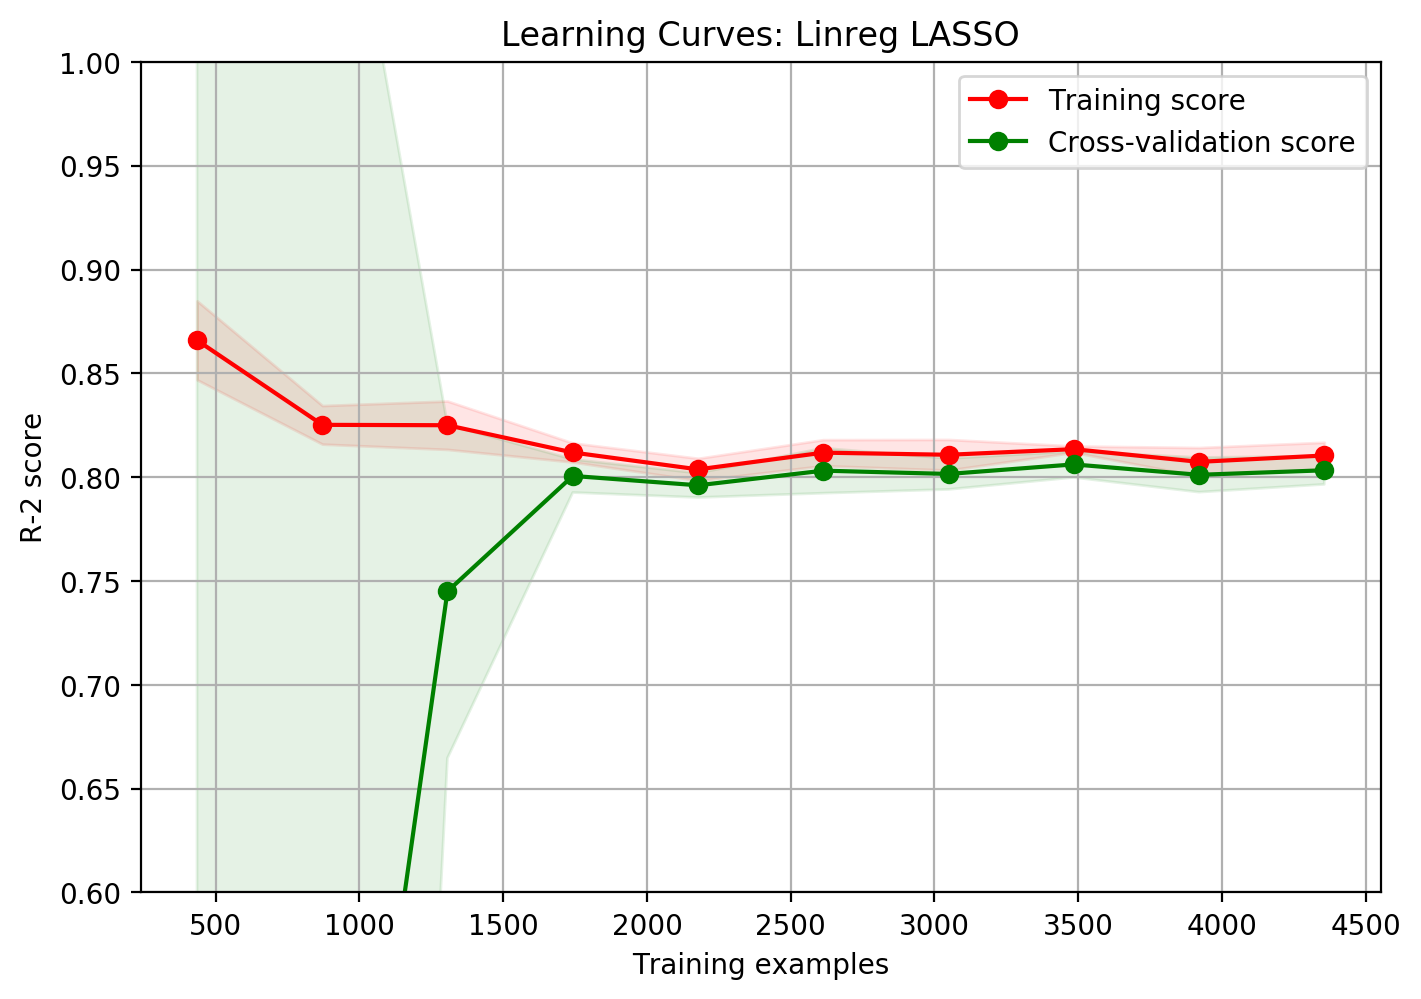

In [35]:
# plot learning curve
title = "Learning Curves: {method}".format(method=method)
plot_learning_curve(model, title, X_train, y_train, cv=cv, ylim=(0.6, 1), figsize=(8, 5.5))
plt.show()